# Sampling from Truncated Distributions [3] 

In the previous post, I claimed that the results of Gibbs sampler are sensitive to the chosen coordinate system. 
In this post I will actually demonstrate this. To this end, I will obtain results for the same example as in the previous post and compare these results to a slightly modified case in which the coordinate system is rotated. I am also sharing some results with the hit-and-run sampler.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import cvxpy as cvx
from os import path
import sys

sys.path.append(path.abspath(path.join(path.abspath('') ,"../../truncsample")))

from truncsample.tmvn import truncmvn

### Changing coordinate systems

The effect of rotation on the density is visualized below. The left panel displays the density in the original coordinate system and the right panel show the same density in a rotated coordinate system.

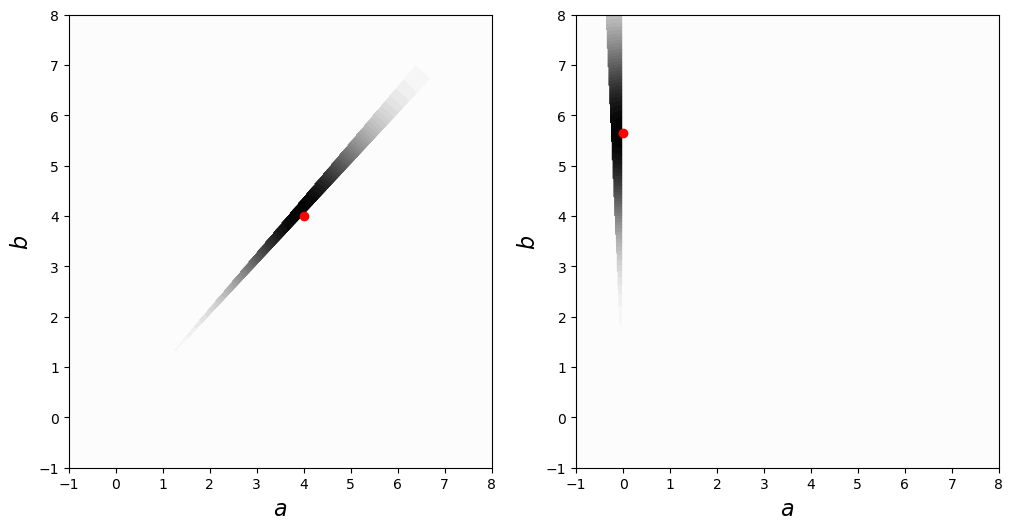

In [2]:
cov     =   True 

F1       =   np.array([[-1,+1],[+1.1,-1]])
g1       =   np.array([1,1])*0
mu1      =   np.array([+4,+4])
M1      =   np.array([[+1,0],[0,+1]])

TMVN1   =   truncmvn(mu1, M1, F1, g1, cov)

F2       =   np.array([[-1,0],[+1.05,0.05]])
g2       =   np.array([1,1])*0
mu2      =   np.array([+0,+np.sqrt(2*4**2)])
M2       =   np.array([[+1,0],[0,+1]])

TMVN2   =   truncmvn(mu2, M2, F2, g2, cov)

linvF1 = np.linalg.pinv(F1)
linvF2 = np.linalg.pinv(F2)

a       =   np.linspace(-1,+8,512);
b       =   np.linspace(-1,+8,512);

na      =   len(a)
nb      =   len(b)
N       =   2
sigpar  =   1
cmap    =   plt.cm.get_cmap("gray")

fig     =   plt.figure(figsize=(12,6),dpi=100)
for d in range(2):
    if d==0:
        TMVN = TMVN1
        fig.add_subplot(121);
    else:
        TMVN = TMVN2
        fig.add_subplot(122);

    mode    =   TMVN.getmode()

    L       =   np.zeros([nb,na])
    for ia in range(0,na):
        for ib in range(0,nb):
            x   =   np.array([a[ia],b[ib]])
            if np.all (TMVN.F.dot (x) + TMVN.g > 0):
                L[ib,ia]   =   np.exp(-( (x[0]-TMVN.mu[0])**2 +(x[1]-TMVN.mu[1])**2 )/(2*sigpar*N) - 1/2*np.log(2*np.pi) - 1/2*np.log(sigpar**2) ) 
            else :
                L[ib,ia]   =   0
    
    
    ax      =   fig.gca()
    
    ax.contourf(a, b,-L/np.max(L),42,cmap='gray')
    plt.plot(mode[0],mode[1],'ro')
    ax.set_xlabel('$a$', fontsize=16)
    ax.set_ylabel('$b$', fontsize=16)
    plt.axis('tight');

#### Results with Gibbs sampling

The next figure displays the biplot and trace plots of the sampled parameters obtained with Gibbs sampling and for the second version of the density (in rotated coordinate system). In this case, there is no visible autocorrelation. 

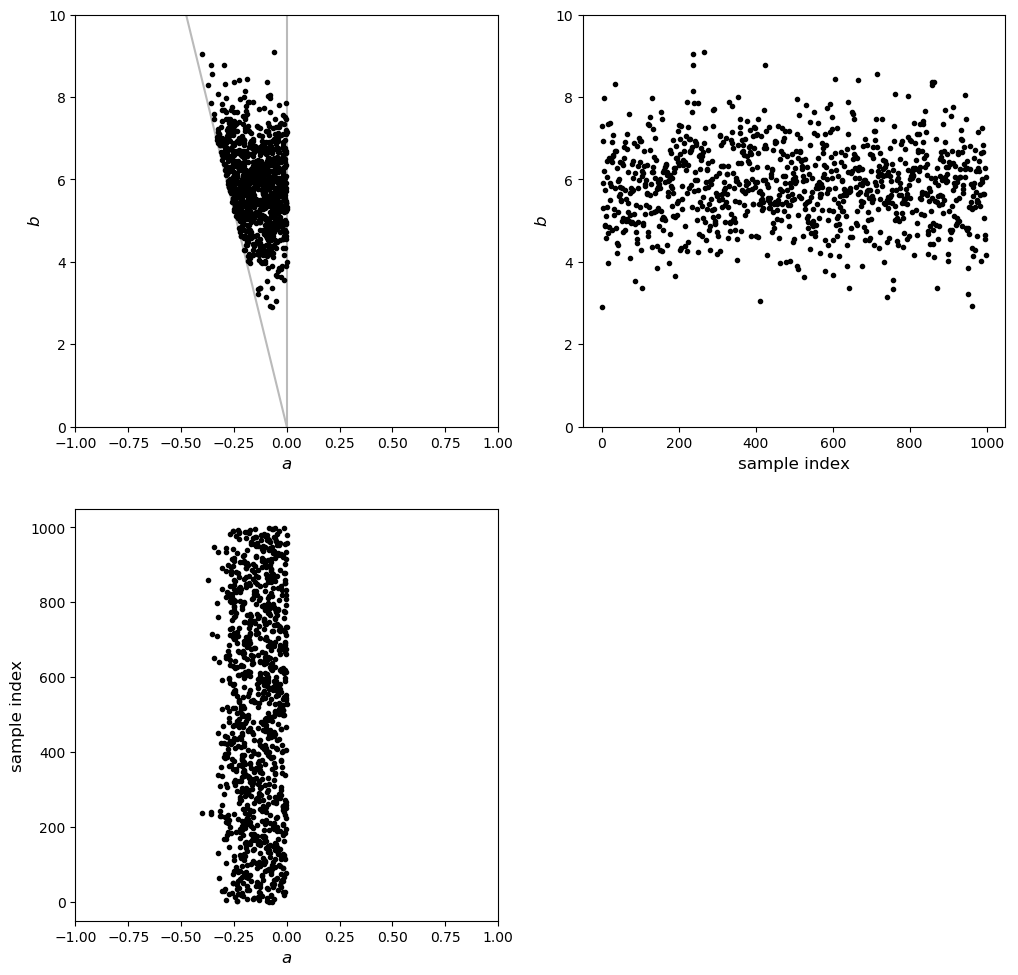

In [3]:
K=1000

u_ = np.linspace(0,.8,2)

ystart = np.array([-0.05,2.05])*np.sqrt(2)
np.random.seed(42)
samples_gibbs,bnc =      TMVN2.sample(K,ystart,sampler="gibbs",verbose=False,visual=False)
fig     =    plt.figure(figsize=(12,12),dpi=100);
fig.add_subplot(221);
ax = fig.gca()
plt.plot(linvF2[0,1]*u_,linvF2[1,1]*u_,'-',Color=np.ones(3)*.73)
plt.plot(linvF2[0,0]*u_,linvF2[1,0]*u_,'-',Color=np.ones(3)*.73)
plt.plot(samples_gibbs[0,:],samples_gibbs[1,:],'k.')
ax.set_xlim((-1, +1))
ax.set_ylim((0, +10))
ax.set_xlabel('$a$', fontsize=12)
ax.set_ylabel('$b$', fontsize=12)
fig.add_subplot(222);
ax = fig.gca()
plt.plot(np.arange(K),samples_gibbs[1,:],'k.')
ax.set_ylim((0,10))
ax.set_xlabel('sample index', fontsize=12)
ax.set_ylabel('$b$', fontsize=12)
fig.add_subplot(223);
ax = fig.gca()
plt.plot(samples_gibbs[0,:],np.arange(K),'k.')
ax.set_xlim((-1, +1))
ax.set_xlabel('$a$', fontsize=12)
ax.set_ylabel('sample index', fontsize=12);

The next figure now displays the results with the original density (in the original coordinate system), again with Gibbs sampling. 
In this case, the samples are clearly autocorrelated, as already observed in the previous post:

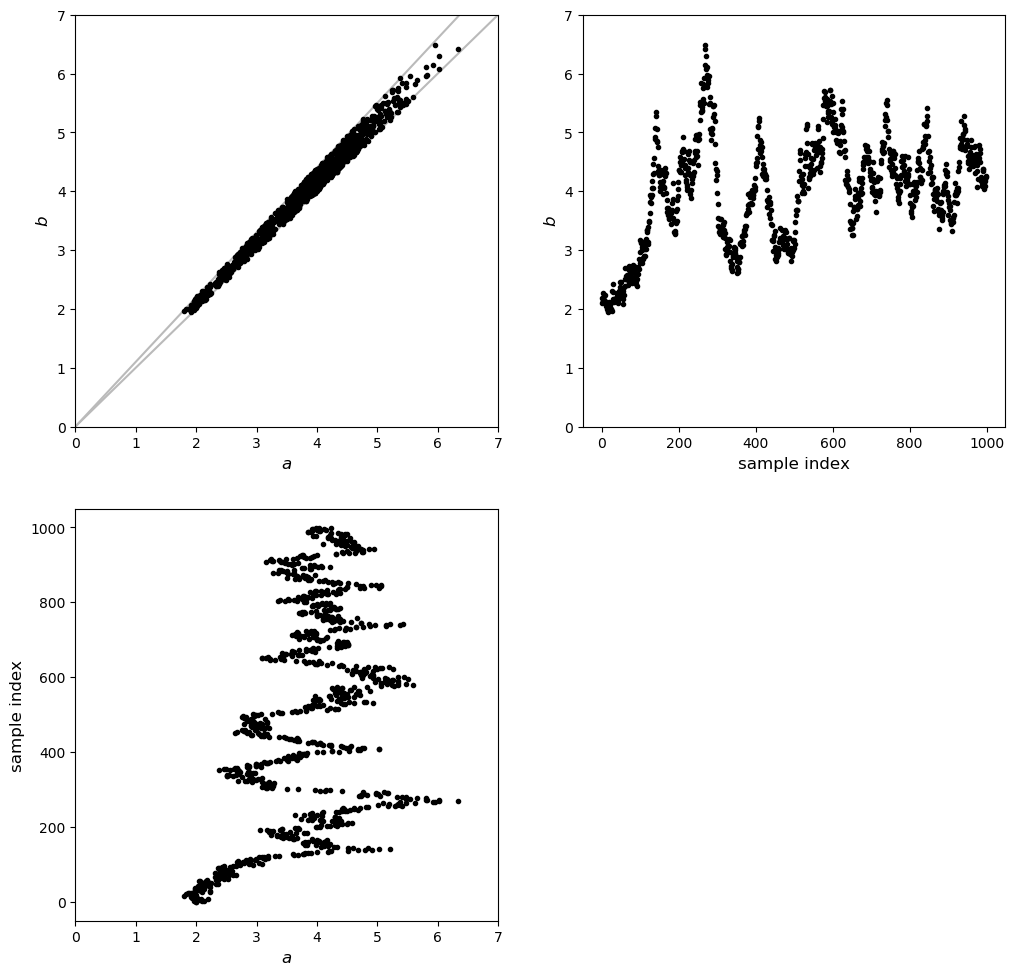

In [4]:
K=1000
np.random.seed(42)

ystart = np.array([2,2.1])
samples_gibbs,bnc =      TMVN1.sample(K,ystart,sampler="gibbs",verbose=False,visual=False)
fig     =    plt.figure(figsize=(12,12),dpi=100);
fig.add_subplot(221);
ax = fig.gca()
plt.plot(linvF1[0,1]*u_,linvF1[0,0]*u_,'-',Color=np.ones(3)*.73)
plt.plot(linvF1[1,1]*u_,linvF1[1,0]*u_,'-',Color=np.ones(3)*.73)
plt.plot(samples_gibbs[0,:],samples_gibbs[1,:],'k.')
ax.set_xlim((0, +7))
ax.set_ylim((0, +7))
ax.set_xlabel('$a$', fontsize=12)
ax.set_ylabel('$b$', fontsize=12)
fig.add_subplot(222);
ax = fig.gca()
plt.plot(np.arange(K),samples_gibbs[1,:],'k.')
ax.set_ylim((0, +7))
ax.set_xlabel('sample index', fontsize=12)
ax.set_ylabel('$b$', fontsize=12)
fig.add_subplot(223);
ax = fig.gca()
plt.plot(samples_gibbs[0,:],np.arange(K),'k.')
ax.set_xlim((0, +7))
ax.set_xlabel('$a$', fontsize=12)
ax.set_ylabel('sample index', fontsize=12);

#### Results with hit-and-run sampling

The next figure displays the biplot and trace plots of the sampled parameters by using hit-and-run sampling for the second version of the density (in rotated coordinate system). In this case, there is no visible autocorrelation for parameter $a$ but the sampled values for $b$ appear to be quite autocorrelated still. 

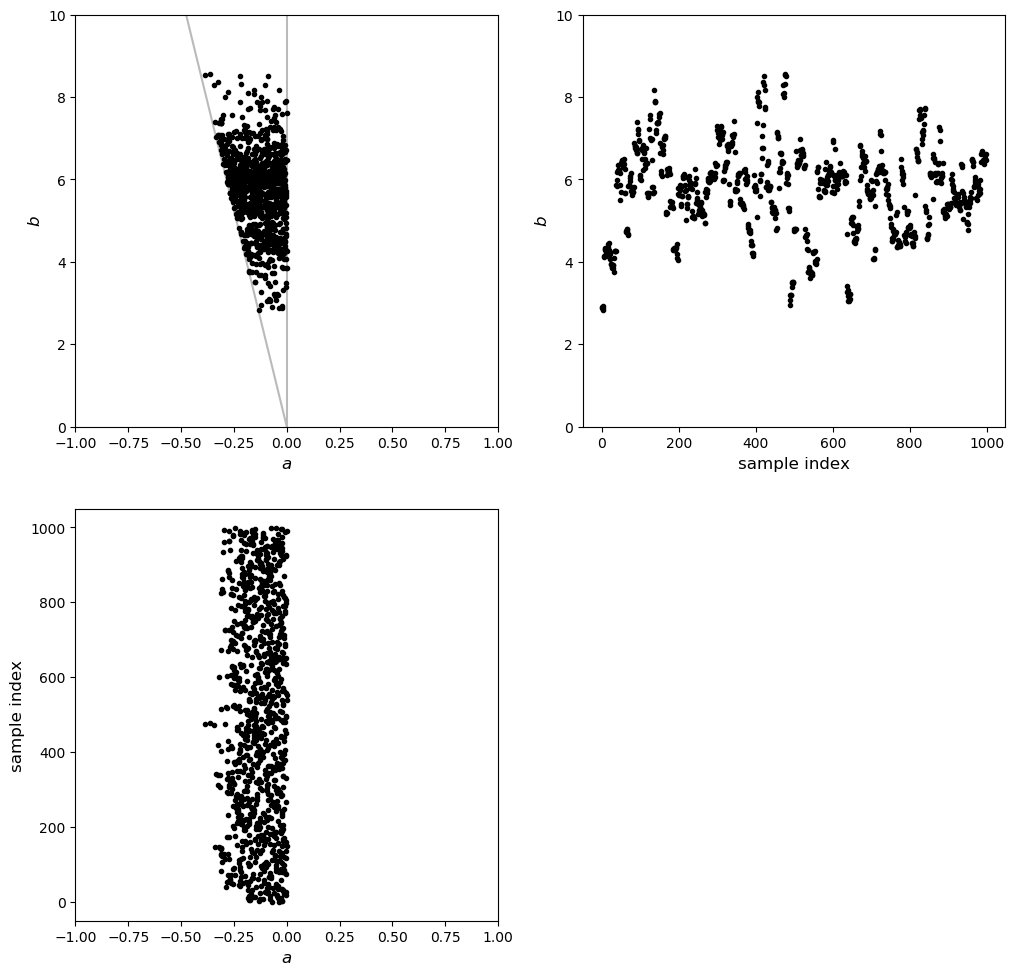

In [5]:
K=1000
linvF = np.linalg.pinv(F2)
u_ = np.linspace(0,.8,2)

ystart = np.array([-0.05,2.05])*np.sqrt(2)
np.random.seed(42)
samples_har,bnc =      TMVN2.sample(K,ystart,sampler="hitandrun",verbose=False,visual=False)
fig     =    plt.figure(figsize=(12,12),dpi=100);
fig.add_subplot(221);
ax = fig.gca()
plt.plot(linvF2[0,1]*u_,linvF2[1,1]*u_,'-',Color=np.ones(3)*.73)
plt.plot(linvF2[0,0]*u_,linvF2[1,0]*u_,'-',Color=np.ones(3)*.73)
plt.plot(samples_har[0,:],samples_har[1,:],'k.')
ax.set_xlim((-1, +1))
ax.set_ylim((0, +10))
ax.set_xlabel('$a$', fontsize=12)
ax.set_ylabel('$b$', fontsize=12)
fig.add_subplot(222);
ax = fig.gca()
plt.plot(np.arange(K),samples_har[1,:],'k.')
ax.set_ylim((0,10))
ax.set_xlabel('sample index', fontsize=12)
ax.set_ylabel('$b$', fontsize=12)
fig.add_subplot(223);
ax = fig.gca()
plt.plot(samples_har[0,:],np.arange(K),'k.')
ax.set_xlim((-1, +1))
ax.set_xlabel('$a$', fontsize=12)
ax.set_ylabel('sample index', fontsize=12);

The next figure now displays the results with the original density (in the original coordinate system), again with hit-and-run. Here we see that both traces exhibit autocorrelation, as already observed in the previous post:

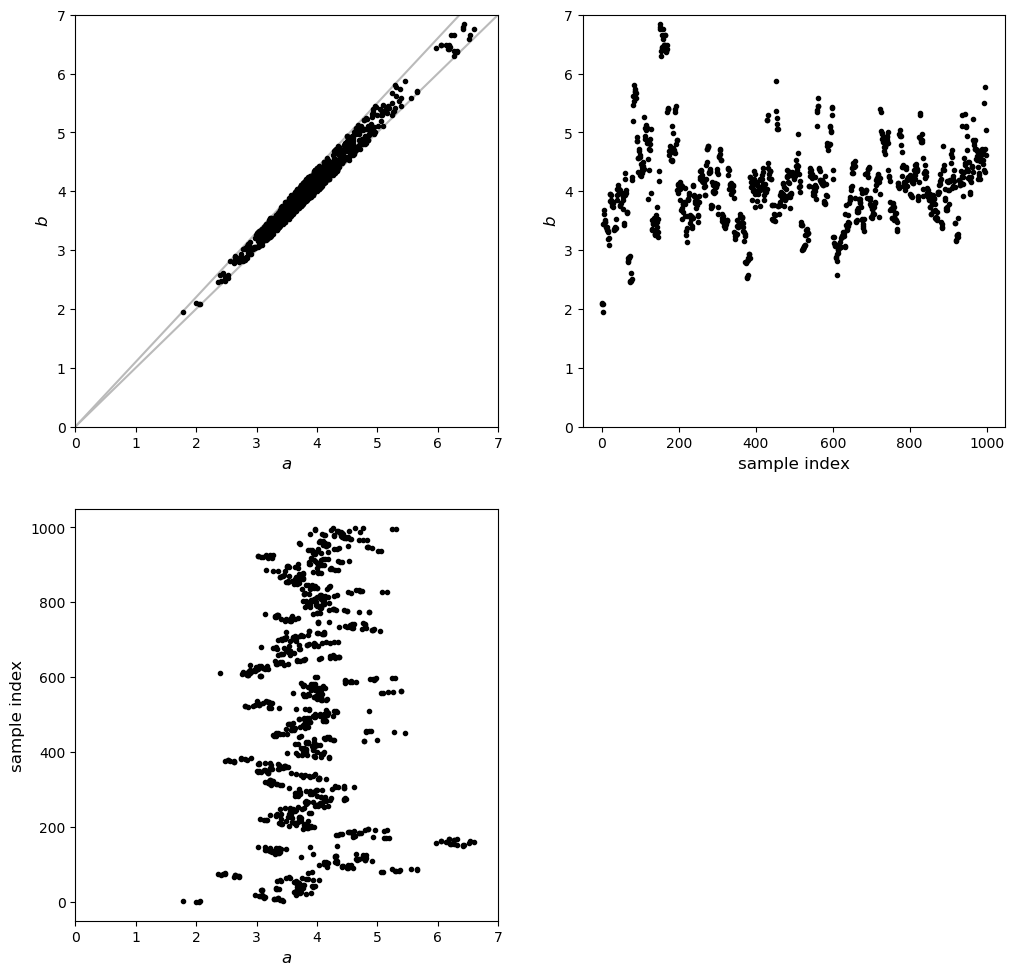

In [6]:
K=1000
np.random.seed(42)

ystart = np.array([2,2.1])
samples_har,bnc =      TMVN1.sample(K,ystart,sampler="hitandrun",verbose=False,visual=False)
fig     =    plt.figure(figsize=(12,12),dpi=100);
fig.add_subplot(221);
ax = fig.gca()
plt.plot(linvF1[0,1]*u_,linvF1[0,0]*u_,'-',Color=np.ones(3)*.73)
plt.plot(linvF1[1,1]*u_,linvF1[1,0]*u_,'-',Color=np.ones(3)*.73)
plt.plot(samples_har[0,:],samples_har[1,:],'k.')
ax.set_xlim((0, +7))
ax.set_ylim((0, +7))
ax.set_xlabel('$a$', fontsize=12)
ax.set_ylabel('$b$', fontsize=12)
fig.add_subplot(222);
ax = fig.gca()
plt.plot(np.arange(K),samples_har[1,:],'k.')
ax.set_ylim((0, +7))
ax.set_xlabel('sample index', fontsize=12)
ax.set_ylabel('$b$', fontsize=12)
fig.add_subplot(223);
ax = fig.gca()
plt.plot(samples_har[0,:],np.arange(K),'k.')
ax.set_xlim((0, +7))
ax.set_xlabel('$a$', fontsize=12)
ax.set_ylabel('sample index', fontsize=12);

### Take home message

* I demonstrated that the Gibbs sampler is sensitive to the choice of coordinate system. In the chosen example, the amount of observed autocorrelation in both parameters can be reduced by means of a suitable rotation

* The hit-and-run sampler appears also sensitive to the choice of coordinate system. In this case, the applied rotation led to a reduction of autocorrelation as well, but only in one of the parameters. This means that the hit-and-run sampler can be outperformed by the Gibbs sampler, provided of course that a suitable rotation exists and can be found.

* The effect of rotation on the rejection sampler is non-existent and is negligable for the HMC sampler in the studied example (not demonstrated). 


### References

[1] Pakman, A., & Paninski, L. (2014). Exact Hamiltonian Monte Carlo for truncated multivariate Gaussians. Journal of Computational and Graphical Statistics, 23(2), 518-542.